# Historical Components Vis
This was first created on September 7th, 2017 for a group meeting talk with the Karnauskas/Lovenduski group meetings. The purpose is to make an illustrative visual (or series of visuals) to look at each component of the historical FG_CO2 time series so that folks know what I am actually characterizing.

In [20]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ocn-clim')

import esmtools as et

# Stats
from scipy import stats
import numpy.polynomial.polynomial as poly

In [21]:
EBU = 'CalCS'
VAR = 'FG_CO2'

# Temp MK Trend Test.
Can't seem to install directly with pip.
Got from : https://up-rs-esp.github.io/mkt/

In [15]:
import numpy as np
from scipy.special import ndtri, ndtr
import sys


def test(t, x, eps=None, alpha=None, Ha=None):
    """
    Runs the Mann-Kendall test for trend in time series data.
    Parameters
    ----------
    t : 1D numpy.ndarray
        array of the time points of measurements
    x : 1D numpy.ndarray
        array containing the measurements corresponding to entries of 't'
    eps : scalar, float, greater than zero
        least count error of measurements which help determine ties in the data
    alpha : scalar, float, greater than zero
        significance level of the statistical test (Type I error)
    Ha : string, options include 'up', 'down', 'upordown'
        type of test: one-sided ('up' or 'down') or two-sided ('updown')
    Returns
    -------
    MK : string
        result of the statistical test indicating whether or not to accept hte
        alternative hypothesis 'Ha'
    m : scalar, float
        slope of the linear fit to the data
    c : scalar, float
        intercept of the linear fit to the data
    p : scalar, float, greater than zero
        p-value of the obtained Z-score statistic for the Mann-Kendall test
    Raises
    ------
    AssertionError : error
                    least count error of measurements 'eps' is not given
    AssertionError : error
                    significance level of test 'alpha' is not given
    AssertionError : error
                    alternative hypothesis 'Ha' is not given
    """
    # assert a least count for the measurements x
    assert eps, "Please provide least count error for measurements 'x'"
    assert alpha, "Please provide significance level 'alpha' for the test"
    assert Ha, "Please provide the alternative hypothesis 'Ha'"

    # estimate sign of all possible (n(n-1)) / 2 differences
    n = len(t)
    sgn = np.zeros((n, n), dtype="int")
    for i in range(n):
        tmp = x - x[i]
        tmp[np.where(np.fabs(tmp) <= eps)] = 0.
        sgn[i] = np.sign(tmp)

    # estimate mean of the sign of all possible differences
    S = sgn[np.triu_indices(n, k=1)].sum()

    # estimate variance of the sign of all possible differences
    # 1. Determine no. of tie groups 'p' and no. of ties in each group 'q'
    np.fill_diagonal(sgn, eps * 1E6)
    i, j = np.where(sgn == 0.)
    ties = np.unique(x[i])
    p = len(ties)
    q = np.zeros(len(ties), dtype="int")
    for k in range(p):
        idx =  np.where(np.fabs(x - ties[k]) < eps)[0]
        q[k] = len(idx)
    # 2. Determine the two terms in the variance calculation
    term1 = n * (n - 1) * (2 * n + 5)
    term2 = (q * (q - 1) * (2 * q + 5)).sum()
    # 3. estimate variance
    varS = float(term1 - term2) / 18.

    # Compute the Z-score based on above estimated mean and variance
    if S > eps:
        Zmk = (S - 1) / np.sqrt(varS)
    elif np.fabs(S) <= eps:
        Zmk = 0.
    elif S < -eps:
        Zmk = (S + 1) / np.sqrt(varS)

    # compute test based on given 'alpha' and alternative hypothesis
    # note: for all the following cases, the null hypothesis Ho is:
    # Ho := there is no monotonic trend
    # 
    # Ha := There is an upward monotonic trend
    if Ha == "up":
        Z_ = ndtri(1. - alpha)
        if Zmk >= Z_:
            MK = "accept Ha := upward trend"
        else:
            MK = "reject Ha := upward trend"
    # Ha := There is a downward monotonic trend
    elif Ha == "down":
        Z_ = ndtri(1. - alpha)
        if Zmk <= -Z_:
            MK = "accept Ha := downward trend"
        else:
            MK = "reject Ha := downward trend"
    # Ha := There is an upward OR downward monotonic trend
    elif Ha == "upordown":
        Z_ = ndtri(1. - alpha / 2.)
        if np.fabs(Zmk) >= Z_:
            MK = "accept Ha := upward OR downward trend"
        else:
            MK = "reject Ha := upward OR downward trend"

    # ----------
    # AS A BONUS
    # ----------
    # estimate the slope and intercept of the line
    m = np.corrcoef(t, x)[0, 1] * (np.std(x) / np.std(t))
    c = np.mean(x) - m * np.mean(t)

    # ----------
    # AS A BONUS
    # ----------
    # estimate the p-value for the obtained Z-score Zmk
    if S > eps:
        if Ha == "up":
            p = 1. - ndtr(Zmk)
        elif Ha == "down":
            p = ndtr(Zmk)
        elif Ha == "upordown":
            p = 0.5 * (1. - ndtr(Zmk))
    elif np.fabs(S) <= eps:
        p = 0.5
    elif S < -eps:
        if Ha == "up":
            p = 1. - ndtr(Zmk)
        elif Ha == "down":
            p = ndtr(Zmk)
        elif Ha == "upordown":
            p = 0.5 * (ndtr(Zmk))
    return MK, m, c, p

# Load in Data

In [16]:
def load_in_filtered_data(VAR, EBU, AW=True):
    """
    Loads in the netCDF files for the ensemble mean and residuals for any inputted variable
    and returns an xarray dataset for the forced signal, residuals, and the total time series
    (simply the sum of the two previous components).
    """
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    return ds_forced, ds_residuals, ds_total

In [17]:
con_mean, con_resid, con_total = load_in_filtered_data(VAR, EBU)

# Compute Each Component
We have four components to visualize here:

1. The historical mean state of the system (level)
2. The seasonal cycle (ensemble mean - trend)
3. The trend (linear trend)
4. The residuals

For clarity:

The red line *should* drift away from the black line. This simply represents the anthropogenic sink (by fitting the ensemble mean with a 4th order fit). The black line is plotted to only show the seasonal cycle component, so it should be stationary. 

In [18]:
t = con_total['time'].values
ensemble_mean = con_mean[VAR + '_AW'].values

# Break down all components
x = np.arange(0, len(t), 1)
coefs = poly.polyfit(x, ensemble_mean, 1)
line_fit = poly.polyval(x, coefs) # This is the trend portion

# Quantifable trend (first order)
slope, _, _, _, _ = stats.linregress(x, ensemble_mean)
slope = slope * len(t)

# I think the "level" or historical state of the system should clearly
# not be the mean of the time series due to the trend. You could either
# just look at the intercept of the linear regression, or the intercept
# of a 4th order polynomial.
b = coefs[0]
level = np.zeros(len(t))
level[:] = b

# Seasonal cycle needs to be detrended, but then scaled back up to the intercept
seasonal_cycle = ensemble_mean 

# Quantification

In [19]:
mean = con_total[VAR + '_AW'].mean().values.round(2)
print("Mean: " + str(mean) + ' (mol/m2/yr)')

print("Intercept: " + str(b.round(2)))

seasonal = con_mean.apply(et.ufunc.seasonal_magnitude)[VAR + "_AW"].values.round(2)
print("Seasonal: " + str(seasonal) + ' (mol/m2/yr)')

internal = con_resid[VAR + '_AW'].std('time').mean('ensemble').values.round(2)
print("Internal: " + str(internal) + ' (mol/m2/yr)')

print("Trend: " + str(slope.round(2)) + '(mol/m2/yr/96yr)')


Mean: -0.42 (mol/m2/yr)
Intercept: -0.27
Seasonal: 0.71 (mol/m2/yr)
Internal: 0.33 (mol/m2/yr)
Trend: -0.31(mol/m2/yr/96yr)


# Test significance of trend.

In [ ]:
tt = np.arange(0,len(con_mean.time))

In [ ]:
MK, m, c, p = test(tt, con_mean[VAR + "_AW"].values, eps=1E-3, alpha=0.05, Ha='down')

In [ ]:
m*1152

In [ ]:
MK

# Master Plot with Everything Included

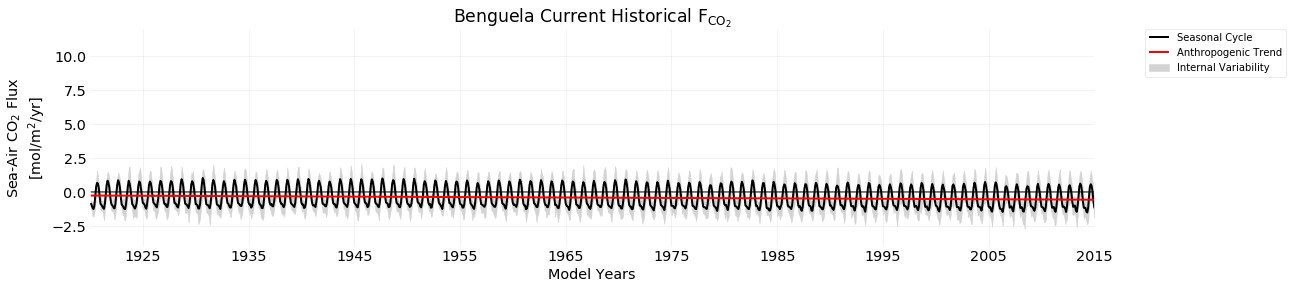

In [8]:
fig = plt.figure(figsize=(18,4))
ax = plt.subplot(111)

# RESIDUALS
#for idx in np.arange(0, 34, 1):
#    data = con_total['FG_CO2_AW'][:, idx].values
#    plt.plot(t, data, color='#d3d3d3', linewidth=1)

# This approach makes it easier to work with in Illustrator.
data_min = con_total[VAR + "_AW"].max('ensemble')
data_max = con_total[VAR + "_AW"].min('ensemble')
plt.fill_between(t, data_min, data_max, color='#d3d3d3', label='Internal Variability')

# SEASONALITY
plt.plot(t, seasonal_cycle, linewidth=2, color='k', label='Seasonal Cycle')

# TREND
plt.plot(t, line_fit, color='r', linewidth=2, label='Anthropogenic Trend')

# LEVEL
#plt.plot(t, level, color='k', linewidth=2, linestyle='--')

# Zero line    
plt.plot(t, np.zeros(len(t)), color='k', linewidth=1)
ax.set(xlim=['1920', '2015'])
ax.set(ylim=[-4, 12])

# Aesthetics
ax.set_title('Benguela Current Historical F$_{\mathrm{CO}_{2}}$')
ax.set_xlabel('Model Years')
ax.set_ylabel('Sea-Air CO$_{2}$ Flux' + '\n' +  '[mol/m$^{2}$/yr]')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Save figure.
#et.vis.savefig('benguela_legend', extension='.eps', dpi=300)

# Just mean seasonal component for inlets

In [100]:
# Taken from esmtools seasonal_magnitude function
def seasonal_cycle(ds):
    x = np.arange(0, len(ds.time), 1)
    coefs = poly.polyfit(x, ds, 4)
    poly_fit = poly.polyval(x, coefs)
    seasonality = (ds - poly_fit)
    climatology = ds.groupby('time.month').mean()
    return climatology

In [101]:
seasonal = con_mean.apply(seasonal_cycle)['FG_CO2_AW']

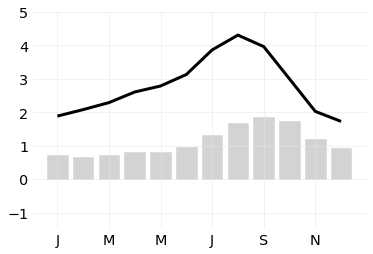

In [103]:
f, ax = plt.subplots()

# Seasonal Cycle
ax.plot(seasonal.month, seasonal, color='k')

# Internal variability magnitude
internal = con_resid['FG_CO2_AW'].groupby('time.month').std('time').mean('ensemble')
ax.bar(internal.month, internal, color='#d3d3d3', edgecolor='#d3d3d3')

#####
ax.set_xticks(np.arange(1,13,2))
ax.set_xticklabels(['J','M','M','J','S','N'])
ax.set_ylim([-1.5,5])
#et.vis.savefig('HumCS_seasonal', extension='.eps', dpi=300)